In [1]:
# %pip install tensorflow
# %pip install opencv-contrib-python
# %pip install utils
# %pip install import_ipynb

**1. Import relevant libraries and packages**

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import random
import cv2
from utils import *

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from copy import deepcopy

**2. Load data**

In [3]:
folder = 'C:\\Users\\HP\\OneDrive - University of Louisiana Lafayette\\Documents\\Louisiana\\3. Fall 2024\\CSCE 566 - Data Mining\\Final Project\\Datasets\\Problem_5_Glaucoma_Detection_using_SLO_and_OCT_Fundus_Images'

data_summary = pd.read_csv(os.path.join(folder, 'data_summary.csv'))
data_summary

,filename,age,gender,race,ethnicity,language,maritalstatus,md,glaucoma,use
0,data_00001.npz,72.37,female,white,non-hispanic,english,widowed,-22.93,yes,training
1,data_00002.npz,62.09,female,white,non-hispanic,english,divorced,1.48,no,training
2,data_00003.npz,68.70,female,white,non-hispanic,english,married or partnered,-19.61,yes,training
3,data_00004.npz,57.07,female,white,non-hispanic,english,married or partnered,1.13,no,training
4,data_00005.npz,47.59,male,white,non-hispanic,english,single,0.44,no,training
...,...,...,...,...,...,...,...,...,...,...
4995,data_09996.npz,59.12,female,white,non-hispanic,english,married or partnered,0.16,no,testing
4996,data_09997.npz,62.00,female,white,non-hispanic,english,married or partnered,0.41,no,testing
4997,data_09998.npz,77.10,female,white,non-hispanic,english,widowed,-9.54,yes,testing
4998,data_09999.npz,44.76,female,white,non-hispanic,english,married or partnered,0.74,no,testing


In [4]:
flist = os.listdir(os.path.join(folder, 'Training'))
print(len(flist))

3000


In [5]:
sample_data = np.load(os.path.join(folder, 'Training', flist[0]))
for i in sample_data.keys():
    print(i)

oct_fundus
slo_fundus
age
gender
race
ethnicity
language
marriagestatus
md
glaucoma


In [6]:
sample_data['oct_fundus'], sample_data['slo_fundus']

(array([[197, 182, 177, ..., 170, 152, 147],
        [193, 191, 189, ..., 146, 135, 138],
        [184, 191, 197, ..., 150, 149, 141],
        ...,
        [189, 185, 188, ..., 192, 186, 187],
        [192, 186, 185, ..., 200, 191, 191],
        [169, 195, 191, ..., 198, 189, 187]], dtype=uint8),
 array([[25, 27, 20, ..., 20, 29, 11],
        [16, 26, 23, ..., 19, 14,  5],
        [21, 22, 23, ..., 14,  9, 11],
        ...,
        [22, 32, 39, ..., 11,  4, 10],
        [47, 35, 43, ..., 15,  5,  7],
        [25, 22, 32, ..., 11,  5, 14]], dtype=uint8))

**Fundus viewer**

In [7]:
def gen_cmap(N=10000):
    
    return matplotlib.colors.LinearSegmentedColormap.from_list("", [(0,'black'), (0.06,'blue'), 
                                                                  (0.23, '#2ab6c6'), (0.38,'yellow'), 
                                                                  (0.6,'red'), (1,'white')], N=N)   



def plot_2dmap(img, show_colorbar=True, show_cup=False, with_ref=False, ref_img=None, delartifact=False, cm=None, title_on=True):
    if cm == None:
        cm = gen_cmap(256)
        
    img_copy2d = deepcopy(img)
    # mark the rim and cup regions by -1 and -2 locations
    if show_cup:
        img_copy2d[img_copy2d==-1] = np.nan
        cm.set_bad("gray")
        cm.set_under(color='lightgray')
    # mark rim and cup regions from reference img
    if with_ref:
        img_copy2d[ref_img==-2] = -2
        img_copy2d[ref_img==-1] = np.nan
        cm.set_bad(color="gray")
        cm.set_under(color='lightgray')
    # delete artifact locations defined by <=30 and >=0
    if delartifact:
        img_copy2d[(img_copy2d<=30) & (img_copy2d>0)] = 0
    fig = plt.figure()
    ax = plt.subplot(111)
    img_copy2d = ax.imshow(img_copy2d, cmap=cm, vmin=-0.00000001, vmax=350)
    if show_colorbar:
        cbar = plt.colorbar(img_copy2d, pad=0.01, aspect=12, location='left')
        cbar.set_ticks([0, 175,350])
        cbar.ax.set_yticklabels(['0 μm', '175 μm', '350 μm'])
        cbar.ax.tick_params(labelsize=14)
        if title_on:
            ax.set_title('RNFL Thickness Map', fontsize=15)
        ax.axis('off')
    else:
        ax.axis('off')
    plt.show()

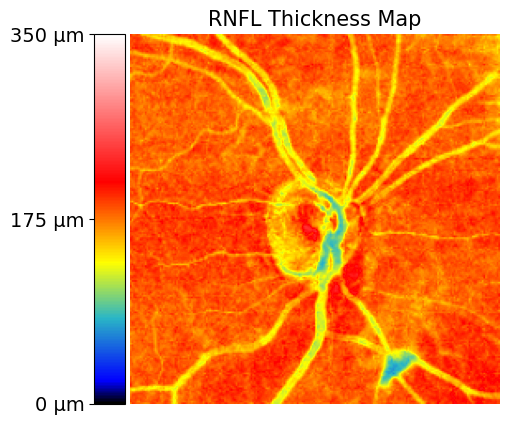

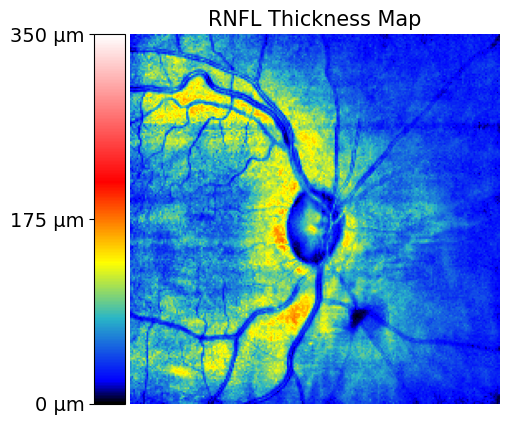

(None, None)

In [8]:
plot_2dmap(sample_data['oct_fundus'], show_cup=False), plot_2dmap(sample_data['slo_fundus'], show_cup=False)

**Data loader**

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, flist, data_path, batch_size=8, dim=(256,256), n_channels=3, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = flist
        self.data_path = data_path
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.uint8)
        y = np.empty((self.batch_size), dtype=np.int32)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            data = np.load(os.path.join(self.data_path, ID))
            img = cv2.resize(data['oct_fundus'], (224,224))
            X[i,] =  np.transpose(np.array([img, img, img]), (1, 2, 0))
            y[i] = data['glaucoma']
            
            # # Process the first image
            # img1 = cv2.resize(data['oct_fundus'], (self.dim[1], self.dim[0]))
            # img1 = np.transpose(np.array([img1, img1, img1]), (1, 2, 0))

            # # Process the second image
            # img2 = cv2.resize(data['slo_fundus'], (self.dim[1], self.dim[0]))
            # img2 = np.transpose(np.array([img2, img2, img2]), (1, 2, 0))

            # # Store both images in X
            # X[i, 0,] = img1
            # X[i, 1,] = img2
            # Store the label
            # y[i] = data['glaucoma']            
        
        return X, y

**Test the data loader**

In [10]:
image_folder = os.path.join(folder, 'Training')

_generator = DataGenerator(flist, image_folder, 
                           batch_size=4, dim=(224,224), 
                           n_channels=3, shuffle=True)

In [11]:
imgs, labs = _generator.__getitem__(0)
len(imgs), labs

(4, array([1, 0, 0, 1]))

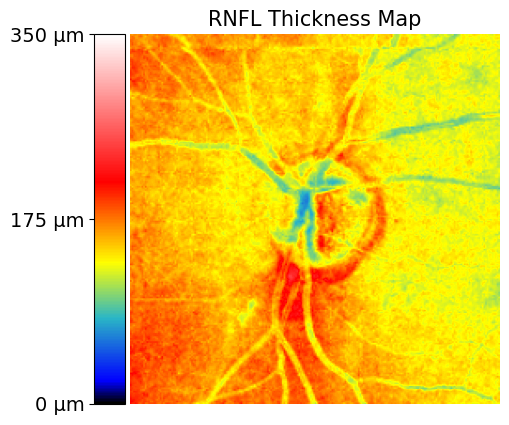

In [12]:
plot_2dmap(imgs[0][:,:,2])

**2. Define the deep learning model**

In [13]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout


def build_model(img_size=224, channel=3):
    img = Input(shape=(img_size, img_size, 3))
    model = tf.keras.applications.efficientnet.EfficientNetB1(
        include_top=False,
        weights='imagenet',
        input_tensor=img,
        pooling=None)
    
    model.trainable = True
    
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x, training=True)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model_cls = Model(inputs=model.input, outputs=output_layer)
    return model_cls



def build_model(img_size=224, channel=3):
    img = Input(shape=(img_size, img_size, 3), name="input")
    model = tf.keras.applications.vgg16.VGG16(
                               weights='imagenet', 
                               include_top=False)

    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x, training=True)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model_cls = Model(inputs=model.input, outputs=output_layer)
    return model_cls

In [14]:
model = build_model()

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │              

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 14,715,201 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**3. Train the model**

In [16]:
batch_size = 100

In [17]:
train_generator = DataGenerator(flist, image_folder, 
                                   batch_size=batch_size, dim=(224, 224), 
                                   n_channels=3, shuffle=True)

model = build_model() 
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', 
                                     metrics = ['acc', tf.keras.metrics.AUC()])

history = model.fit(train_generator, 
                    steps_per_epoch = int(len(flist)/batch_size), 
                    epochs = 2)

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 3424s 114s/step - acc: 0.5425 - auc: 0.5216 - loss: 1.0577
Epoch 2/2
30/30 ━━━━━━━━━━━━━━━━━━━━ 3414s 114s/step - acc: 0.6485 - auc: 0.6553 - loss: 0.6484


**4. Evaluate the model**

In [42]:
path_attr_map = {}
for index, row in data_summary.iterrows():
    # path_attr_map[row['filename']+'.npz'] = [row['race'], row['ethnicity'], row['gender']]
    path_attr_map[row['filename']] = [row['race'], row['ethnicity'], row['gender']]

In [43]:
flist_test = os.listdir(os.path.join(folder, 'Testing'))
test_folder = os.path.join(folder, 'Testing')

In [44]:
test_generator = DataGenerator(flist_test, test_folder, 
                               batch_size=batch_size, dim=(224,224), 
                               n_channels=3, shuffle=True)

test_y = []
pred_y = []
test_paths = []
test_attrs = []
indexes = np.arange(len(flist_test))
for i in range(test_generator.__len__()):
    batch_X, batch_y = test_generator.__getitem__(i)
    pred_batch_y = model.predict(batch_X, verbose=0)
    test_y.extend(batch_y)
    pred_y.extend(np.squeeze(pred_batch_y))
    test_paths.extend([flist_test[idx] for idx in indexes[i*batch_size:(i+1)*batch_size]])
    test_attrs.extend([path_attr_map[flist_test[idx]] for idx in indexes[i*batch_size:(i+1)*batch_size]])

# # perfs = eval_test(test_y, pred_y, test_attrs)

**Overall performance**

In [45]:
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.metrics import auc, confusion_matrix

def cal_auc(test_y, pred_y, msg='Overall'):        
    test_y = np.array(test_y)
    test_pred = np.array(pred_y)

    fpr, tpr, thresholds = roc_curve(test_y, test_pred)
    Auc = auc(fpr, tpr)
    
    print(msg, Auc)
    
    return Auc

In [46]:
auc_overall = cal_auc(test_y, pred_y, 'Overall')
print(auc_overall)

Overall 0.709931110348034
0.709931110348034


0.709931110348034 0.648 
 [[986 127]
 [577 310]]


C:\Users\HP\AppData\Local\Temp\ipykernel_4700\3601941004.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='red')


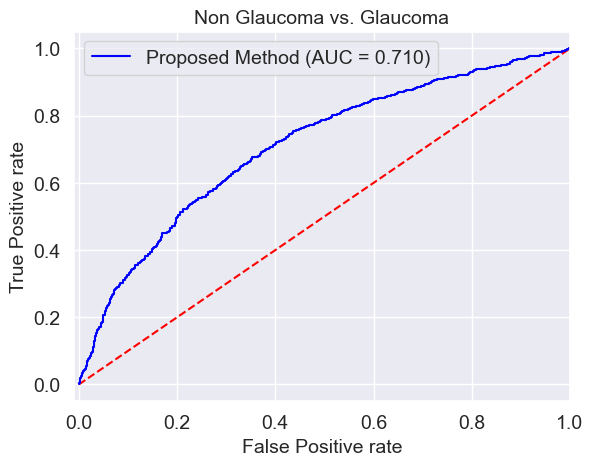

In [47]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc_score = auc(fpr, tpr)
acc = accuracy_score(test_y, np.rint(pred_y))
cfmat = confusion_matrix(test_y, np.rint(pred_y))
print(auc_score, acc, '\n', cfmat)


plt.tick_params(axis='both', which='major', labelsize=14)
plt.plot([0, 1], [0, 1], 'k--', color='red')
plt.plot(fpr, tpr, label='Proposed Method (AUC = {:.3f})'.format(auc_score), color='blue')
plt.xlim([-0.01, 1.0])
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)
plt.xlabel('False Positive rate', fontsize=14)
plt.ylabel('True Positive rate', fontsize=14)
plt.title('Non Glaucoma vs. Glaucoma', fontsize=14)
plt.legend(loc='best', fontsize=14)
# plt.show()

# plt.savefig('results/roc_curve.jpg',
#             dpi=600,
#             orientation='portrait',
#             bbox_inches='tight', pad_inches=0)

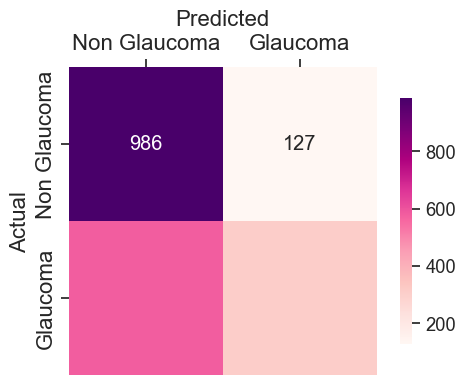

In [93]:
# Create the figure
fig6 = plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)

# Generate heatmap
y = ['Non Glaucoma', 'Glaucoma']
ax = sns.heatmap(cfmat, annot=True, cmap='RdPu', fmt="d", square=True, xticklabels=y, yticklabels=y, cbar_kws={"shrink": 0.8})
# ax = sns.heatmap(cfmat, annot=True ,vmin=0, vmax=90, square=True, xticklabels=y, yticklabels=y, cmap='RdPu', fmt="d", cbar_kws={"shrink": 0.8})
ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.set_xticklabels(y, fontsize=16)
ax.set_yticklabels(y, fontsize=16)
plt.title("Predicted", fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.yticks(rotation=90) 
plt.xticks(rotation=0)

# Displays the heatmap
plt.show()

**Subgroup performance**

In [56]:
test_y_race = {'White':[], 'Black':[], 'Asian':[]}
pred_y_race = {'White':[], 'Black':[], 'Asian':[]}
test_y_hispanic = {'Non_hispanic':[], 'Hispanic':[]}
pred_y_hispanic = {'Non_hispanic':[], 'Hispanic':[]}
test_y_gender = {'Female':[], 'Male':[]}
pred_y_gender = {'Female':[], 'Male':[]}


for i in range(len(test_attrs)):
    params = test_attrs[i]
    
    race = str(params[0])
    ethinicity = str(params[1])
    gender = str(params[2])
    
    if race == 'White'.lower():#7:
        test_y_race['White'].append(test_y[i])
        pred_y_race['White'].append(pred_y[i])
    elif race == 'Black or African American'.lower():#2:
        test_y_race['Black'].append(test_y[i])
        pred_y_race['Black'].append(pred_y[i])
    elif race == 'Black'.lower():#2:
        test_y_race['Black'].append(test_y[i])
        pred_y_race['Black'].append(pred_y[i])
    elif race == 'Asian'.lower():#3:
        test_y_race['Asian'].append(test_y[i])
        pred_y_race['Asian'].append(pred_y[i])

    if ethinicity == 'non-hispanic':
        test_y_hispanic['Non_hispanic'].append(test_y[i])
        pred_y_hispanic['Non_hispanic'].append(pred_y[i])
    elif ethinicity == 'hispanic':
        test_y_hispanic['Hispanic'].append(test_y[i])
        pred_y_hispanic['Hispanic'].append(pred_y[i])

    if gender == 'female':
        test_y_gender['Female'].append(test_y[i])
        pred_y_gender['Female'].append(pred_y[i])
    elif gender == 'male':
        test_y_gender['Male'].append(test_y[i])
        pred_y_gender['Male'].append(pred_y[i])

In [51]:
for k in test_y_gender.keys():
    auc_gender = cal_auc(test_y_gender[k], pred_y_gender[k], k)

Female 0.701589796265118
Male 0.7339997334399574


In [55]:
for k in test_y_hispanic.keys():
    auc_gender = cal_auc(test_y_hispanic[k], pred_y_hispanic[k], k)

Non_hispanic 0.7105154639175257
Hispanic 0.6968272620446534


In [57]:
for k in test_y_race.keys():
    auc_gender = cal_auc(test_y_race[k], pred_y_race[k], k)

White 0.7080727964525019
Black 0.7264287001983054
Asian 0.7


**5. Save the model**

In [49]:
model.save(f"results/oct_predict_glaucoma_model.h5")
np.savez(f"results/oct_predict_glaucoma_model.npz", 
         test_y=test_y, 
         test_pred=pred_y,
         test_attrs=test_attrs,
         test_paths=test_paths)